In [ ]:
'''
https://drive.google.com/drive/folders/1aUHmku3Ohd_GGAdLf6E-TwKv2k4w7Wfr?usp=sharing
'''

In [1]:
# Các Thư Viện Cần Cho Quá Trình Train - Predict - Trực Quan Hoá Dữ Liệu
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch import flatten
from torchvision import models
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import torchvision.transforms as transforms
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

Các Quá Trình Dưới Đây Sẽ Ví Dụ Cụ Thể Chi Tiết Bắt Đầu Từ Việc:
    1. Đọc Data
    2. Xử Lí Data (Bao gồm các bước loại bỏ các loại data nhiễu, nhóm các  loại data, ...)
    3.  Phân Chia Tập Train-Valid-Test
    4. Sử dụng SVM với các Kernel khác nhau, đồng thời dùng KFold để so sánh và đánh giá kết quả thông qua quá trình Train và Predict.

In [5]:
# Trước Hết Ta Sẽ Xem Nhiệm Vụ Chính Của SVM thông qua ví dụ dưới đây. #
# Ta sẽ tạo 2 lớp dữ liệu, ta sẽ đặt tên cho nó là xanh và đỏ
# 1 mảng sẽ được tạo để chứa cả 2 lớp dữ liệu 
# và 1 mảng khác dùng để label(xanh, đỏ) nhận biết lớp dữ liệu
X1 = [[1,3], [3,3], [4,0], [3,0], [2, 2]]
y1 = [1, 1, 1, 1, 1]
X2 = [[0,0], [1,1], [1,2], [2,0]]
y2 = [-1, -1, -1, -1]
X = np.array(X1 + X2)
y = y1 + y2

clf = SVC(kernel='linear', C=1E10)
clf.fit(X, y)
print(clf.support_vectors_)

[[1. 2.]
 [1. 3.]
 [3. 0.]]


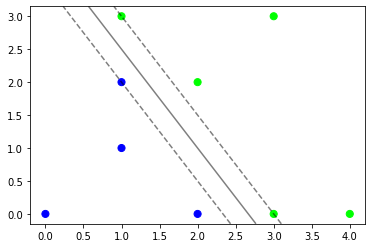

In [25]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='brg')
# Tạo Plot
ax = plt.gca()
# Ta sẽ set lim auto dựa vào giá trị trong data plot
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Vẽ các grid dự trên thông số x, y (ví dụ nếu max(x) = 5 và các giá trị trong x là số nguyên từ 1 -> 5
# thì grid(vạch mức) sẽ được vẽ với bước nhảy dựa vào x và y)
x = np.linspace(xlim[0], xlim[1], 30)
y = np.linspace(ylim[0], ylim[1], 30)
Y, X = np.meshgrid(y, x)
######################################################
xy = np.vstack([X.ravel(), Y.ravel()]).T 
# Vstack là dạng vertical(dọc), dữ liệu có dạng cột như
# [[[1, 2], [tên label]],
#  [[1, 3], [tên label]],
#  [[3, 4], [tên label]]]                                                
P = clf.decision_function(xy).reshape(X.shape)

# plot decision boundary and margins
ax.contour(X, Y, P, colors='k',
            levels=[-1, 0, 1], alpha=0.5,
            linestyles=['--', '-', '--'])

# plot support vectors

ax.scatter(clf.support_vectors_[:, 0],
            clf.support_vectors_[:, 1],
            s=300, linewidth=1, facecolors='none')
ax.set_xlim(xlim)
ax.set_ylim(ylim)


plt.show()

In [92]:
# Chay AlexNet
model_alexnet = models.alexnet(pretrained=True)
#model_alexnet.eval()

In [93]:
model_alexnet.classifier = model_alexnet.classifier[0:len(model_alexnet.classifier)-1]
model_alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Ta sẽ sử dụng Dataset Fashion MNIST trích xuất đặc trưng bằng AlexNet trên và dùng SVM kết hợp GridSearch để đi tìm bộ siêu tham số tốt cho SVM 

In [28]:
def unpickle(file):
  import pickle
  with open(file, 'rb') as fo:
      dict_ = pickle.load(fo, encoding='bytes')
  return dict_

In [29]:
def load_mnist(path, kind='t10k'):
    import gzip
    labels_path = os.path.join(path,'%s-labels-idx1-ubyte.gz'% kind)
    images_path = os.path.join(path,'%s-images-idx3-ubyte.gz'% kind)
    with gzip.open(labels_path, 'rb') as lbpath: labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(labels), 784)

    return images, labels

In [33]:
def load_mnist(path, kind='t10k'):
    import os
    import gzip
    import numpy as np
    labels_path = os.path.join(path,'%s-labels-idx1-ubyte.gz'% kind)
    images_path = os.path.join(path,'%s-images-idx3-ubyte.gz'% kind)
    with gzip.open(labels_path, 'rb') as lbpath: labels = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(labels), 784)

    return images, labels

In [61]:
train_images, labels = load_mnist('./dataset/',kind='train')

In [62]:
test_images, test_labels = load_mnist('./dataset/', kind='t10k')

In [94]:
transform = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(227),
    transforms.ToTensor()
])

D:\anaconda\envs\snowflakes\lib\site-packages\torchvision\transforms\transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [96]:
def processing(input_img): 
    img_ = np.reshape(input_img, (28,28))
    img_pil_ = Image.fromarray(img_)
    img_pil = Image.merge("RGB",(img_pil_, img_pil_, img_pil_))
    to_tensor = transform(img_pil)
    to_tensor.unsqueeze_(0)
    to_var = Variable(to_tensor)
    to_feature = model_alexnet(to_var)
    to_out = np.squeeze(to_feature.data)
    return to_out

In [98]:
# load train and test
train = []
test = []
for i in range(60000):
    if i < 10000:
        img_test = test_images[i]
        test_feature = processing(img_test)
        test.append(test_feature)
    img_train = train_images[i]
    train_feature = processing(img_train)
    train.append(train_feature)
print(len(train), len(test))

60000 10000


In [100]:
sample = ['T-shirt/top' , 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 	'Ankle boot']

In [101]:
# Set up parameters 
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'sigmoid', 'linear']}

In [102]:
train_ = [np.array(i, dtype=float) for i in train]
test_ = [np.array(i, dtype=float) for i in test]

In [103]:
# Chia tập train và tập tìm para
x_train, para_x, y_train, para_y = train_test_split(train_, labels, test_size=0.1, random_state=19520197)

In [104]:
para_x_train, para_x_test, para_y_train, para_y_test = train_test_split(para_x, para_y, test_size=0.2, random_state=19521281)

In [105]:
# Tìm super para
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
grid.fit(para_x_train, para_y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.106 total time= 1.9min
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.106 total time= 1.9min
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.106 total time= 2.2min
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.107 total time= 2.2min
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.107 total time= 1.8min
[CV 1/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.106 total time= 1.2min
[CV 2/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.106 total time= 1.2min
[CV 3/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.106 total time= 1.2min
[CV 4/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.107 total time= 1.2min
[CV 5/5] END ....C=0.1, gamma=1, kernel=sigmoid;, score=0.107 total time= 1.2min
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.828 total time=  11.9s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'sigmoid', 'linear']},
             verbose=3)

In [114]:
# Show best parameters
# print best parameter after tuning
best_param = grid.best_params_
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

# print best score
print(grid.best_score_)

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=10, gamma=0.001)
0.8489583333333334


In [107]:
# classification report
print(classification_report(para_y_test, grid.predict(para_x_test)))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       124
           1       0.98      0.97      0.98       126
           2       0.80      0.75      0.78       120
           3       0.80      0.86      0.83       110
           4       0.80      0.75      0.77       134
           5       0.90      0.93      0.91       102
           6       0.68      0.66      0.67       113
           7       0.93      0.90      0.92       127
           8       0.95      0.97      0.96       119
           9       0.94      0.95      0.95       125

    accuracy                           0.86      1200
   macro avg       0.86      0.86      0.86      1200
weighted avg       0.86      0.86      0.86      1200



In [129]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    name_model = ''
    if 'Modified' in title:
        
        name_model = 'Modified_SVM'
    else:
        if 'Default' in title:
            name_model = 'Default_SVM'
        else:
            name_model = 'Linear_SVM'
    plt.savefig(f'./{name_model}.png', dpi=300, bbox_inches='tight')

In [112]:
y_train = [sample[i] for i in y_train]
test_labels = [sample[i] for i in test_labels]

In [115]:
print(best_param)

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


In [116]:
# Dùng Parameters vừa tìm được train tập data
modified_clf = SVC(C=best_param['C'], kernel=best_param['kernel'], gamma=best_param['gamma'])
modified_clf.fit(x_train, y_train)
print("---Result of Modified SVC with hyperparameters---")
print("Train score: ", modified_clf.score(x_train, y_train))
print("Test score: ", modified_clf.score(test_, test_labels))


---Result of Modified SVC with hyperparameters---
Train score:  0.9660185185185185
Test score:  0.8887


Confusion matrix, without normalization
[[832   2  18  29   6   0 103   0   8   2]
 [  3 971   3  16   2   0   4   0   1   0]
 [ 14   0 828  10  80   0  67   0   1   0]
 [ 18   6  13 892  36   0  34   0   1   0]
 [  2   1  63  27 837   0  66   0   4   0]
 [  0   0   0   0   0 963   0  28   1   8]
 [127   1  68  33  80   1 676   0  13   1]
 [  0   0   0   0   0  15   0 960   0  25]
 [  2   0   2   2   7   2   6   0 977   2]
 [  0   0   1   0   0   7   0  41   0 951]]
              precision    recall  f1-score   support

 T-shirt/top       0.96      0.95      0.96      1000
     Trouser       0.97      0.98      0.97      1000
    Pullover       0.80      0.84      0.82      1000
       Dress       0.88      0.89      0.89      1000
        Coat       0.83      0.83      0.83      1000
      Sandal       0.97      0.96      0.97      1000
       Shirt       0.71      0.68      0.69      1000
     Sneaker       0.93      0.96      0.95      1000
         Bag       0.83      0.83      0.8

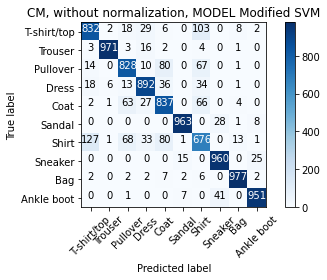

In [118]:
# Predict Modified SVM
y_pred = modified_clf.predict(test_)
cnf_matrix_nb = confusion_matrix(test_labels, y_pred, labels=sample)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_nb, classes=sample,
                      title=f'CM, without normalization, MODEL Modified SVM')
print(classification_report(test_labels, y_pred,target_names=sample))

In [119]:
#Lưu data của Modified SVM
import joblib
joblib.dump(modified_clf, 'Modified_SVM.pkl')

['Modified_SVM.pkl']

In [120]:
# Dùng Default Parameters
default_clf = SVC()
default_clf.fit(x_train, y_train)
print("---Result of Default SVC---")
print("Train score: ", default_clf.score(x_train, y_train))
print("Test score: ", default_clf.score(test_, test_labels))


---Result of Modified SVC with hyperparameters---
Train score:  0.8848148148148148
Test score:  0.8674


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Confusion matrix, without normalization
[[833   1  24  41   8   0  83   0   9   1]
 [  2 965   3  22   0   0   6   0   2   0]
 [ 10   1 780  11 100   0  96   0   2   0]
 [ 21   7  10 879  38   0  44   0   1   0]
 [  1   1  85  39 784   0  87   0   3   0]
 [  0   0   0   1   0 939   0  45   0  15]
 [158   1  76  39  86   1 621   0  17   1]
 [  0   0   0   0   0  22   0 951   1  26]
 [  2   0   1   6   6   4   9   0 970   2]
 [  0   0   1   1   0   9   0  37   0 952]]
              precision    recall  f1-score   support

 T-shirt/top       0.95      0.95      0.95      1000
     Trouser       0.97      0.97      0.97      1000
    Pullover       0.77      0.78      0.78      1000
       Dress       0.85      0.88      0.86      1000
        Coat       0.80      0.78      0.79      1000
      Sandal       0.96      0.94      0.95      1000
       Shirt       0.66      0.62      0.64      1000
     Sneaker       0.92      0.95      0.94      1000
         Bag       0.81      0.83      0.8

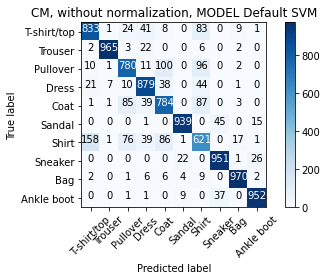

In [122]:
# Predict Default SVM
y_pred = default_clf.predict(test_)
cnf_matrix_nb = confusion_matrix(test_labels, y_pred, labels=sample)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_nb, classes=sample,
                      title=f'CM, without normalization, MODEL Default SVM')
print(classification_report(test_labels, y_pred,target_names=sample))

In [121]:
#Lưu data của Default SVM
joblib.dump(default_clf, 'Default_SVM.pkl')

['Default_SVM.pkl']

In [130]:
# Dùng Linear Kernel
linear_clf = SVC(kernel='linear')
linear_clf.fit(x_train, y_train)
print("---Result of Default SVC---")
print("Train score: ", linear_clf.score(x_train, y_train))
print("Test score: ", linear_clf.score(test_, test_labels))

---Result of Default SVC---
Train score:  0.9677222222222223
Test score:  0.8631


Confusion matrix, without normalization
[[776   2  37  32  13   1 125   0  13   1]
 [  4 976   1  12   0   0   5   0   2   0]
 [ 15   1 786   9 115   0  70   0   4   0]
 [ 26  12  15 856  38   0  47   0   6   0]
 [  3   1  83  32 789   0  89   0   3   0]
 [  0   0   0   0   0 953   0  30   0  17]
 [131   4  89  41  93   0 627   0  14   1]
 [  0   0   0   0   0  22   0 945   2  31]
 [  2   1   0   4   3   2   8   0 977   3]
 [  0   0   0   0   0  12   0  42   0 946]]
              precision    recall  f1-score   support

 T-shirt/top       0.95      0.95      0.95      1000
     Trouser       0.96      0.98      0.97      1000
    Pullover       0.75      0.79      0.77      1000
       Dress       0.87      0.86      0.86      1000
        Coat       0.78      0.79      0.78      1000
      Sandal       0.96      0.95      0.96      1000
       Shirt       0.65      0.63      0.64      1000
     Sneaker       0.93      0.94      0.94      1000
         Bag       0.81      0.78      0.7

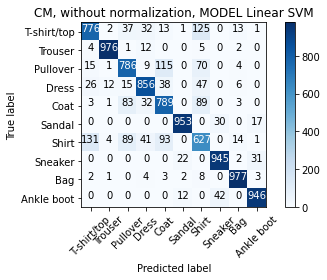

In [131]:
# Predict Linear Kernel
y_pred = linear_clf.predict(test_)
cnf_matrix_nb = confusion_matrix(test_labels, y_pred, labels=sample)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_nb, classes=sample,
                      title=f'CM, without normalization, MODEL Linear SVM')
print(classification_report(test_labels, y_pred,target_names=sample))

In [132]:
#Lưu data của Linear SVM
joblib.dump(linear_clf, 'Linear_SVM.pkl')

['Linear_SVM.pkl']

In [133]:
# Load data đã train của Modified SVM, Default SVM, Linear SVM
pre_modified_clf = joblib.load('Modified_SVM.pkl')
pre_default_clf = joblib.load('Default_SVM.pkl')
pre_linear_clf = joblib.load('Linear_SVM.pkl')

In [134]:
def showImage(image):
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()

True Predict: Dress 
 Default predict: ['Dress'] 
 Modified predict: ['Dress'] 
 Linear predict: ['Dress']


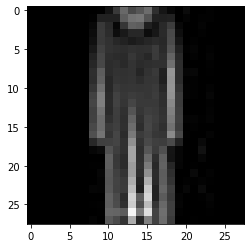

True Predict: Dress 
 Default predict: ['Trouser'] 
 Modified predict: ['Trouser'] 
 Linear predict: ['Dress']


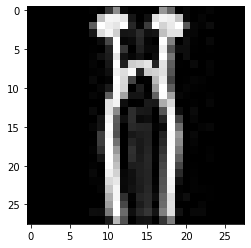

True Predict: T-shirt/top 
 Default predict: ['T-shirt/top'] 
 Modified predict: ['T-shirt/top'] 
 Linear predict: ['T-shirt/top']


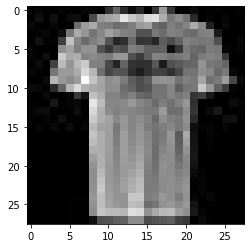

True Predict: Ankle boot 
 Default predict: ['Ankle boot'] 
 Modified predict: ['Ankle boot'] 
 Linear predict: ['Ankle boot']


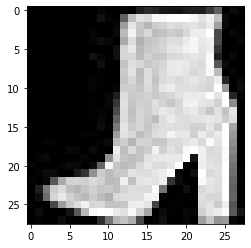

True Predict: Pullover 
 Default predict: ['Coat'] 
 Modified predict: ['Coat'] 
 Linear predict: ['Coat']


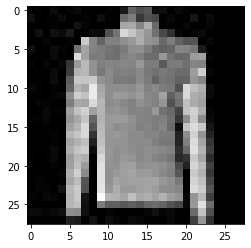

True Predict: Pullover 
 Default predict: ['Coat'] 
 Modified predict: ['Pullover'] 
 Linear predict: ['Pullover']


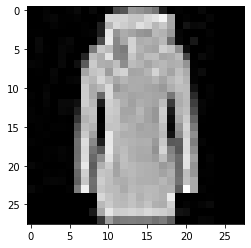

True Predict: Pullover 
 Default predict: ['Shirt'] 
 Modified predict: ['Pullover'] 
 Linear predict: ['Pullover']


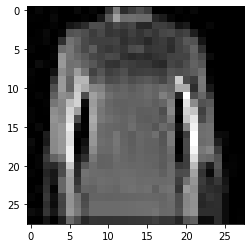

True Predict: Dress 
 Default predict: ['Shirt'] 
 Modified predict: ['Shirt'] 
 Linear predict: ['Pullover']


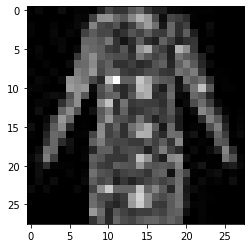

True Predict: Pullover 
 Default predict: ['Pullover'] 
 Modified predict: ['Pullover'] 
 Linear predict: ['Pullover']


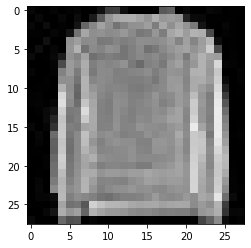

True Predict: Coat 
 Default predict: ['Coat'] 
 Modified predict: ['Coat'] 
 Linear predict: ['Coat']


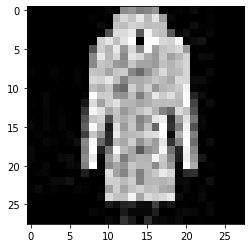

In [135]:
import cv2
n_test = np.random.randint(10000-10)
for i in range(n_test, n_test+10):
    _img_ = Image.open('./test_fashion/test' + str(i) + '.jpg')
    ft = processing(_img_)
    ft = np.array(ft, dtype=float)
    default_pred = pre_default_clf.predict([ft])
    modified_pred = pre_modified_clf.predict([ft])
    linear_pred = pre_linear_clf.predict([ft])
    print(f'True Predict: {test_labels[i]}','\n',f'Default predict: {default_pred}', '\n', f'Modified predict: {modified_pred}','\n', f'Linear predict: {linear_pred}')
    showImage(cv2.imread('./test_fashion/test' + str(i) + '.jpg'))